In [1]:
import sys
import os
sys.path.append('/home/563/slf563/code/gadi/jk72/CMIP_eval/')
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import seaborn as sns
import xarray as xr
import xesmf as xe
import cmocean
from cartopy.util import add_cyclic_point
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
run = 'historical'

In [3]:
tstart = '2000-03-01'
tend = '2013-11-30'

In [4]:
def get_data(var):
    print('Reading {}'.format(var))
    fname = '/g/data/jk72/slf563/CMIP6/CMIP6_radiation_ensemble_{}.nc'.format(var)
    if os.path.isfile(fname):
        
        models_all = xr.open_dataset(fname)
    
    else:  
        tmp_list = file_list[(file_list.variable==var)]
        for i in range(len(tmp_list)):
            fdir = '{}/*.nc'.format(tmp_list.path.iloc[i])
            data = xr.open_mfdataset(fdir)
            data = data.sel(time=slice(tstart,tend))
            data = data.assign_coords({'Model':'{}'.format(tmp_list.source_id.iloc[i])})
            data = data.assign_coords({'Scenario':tmp_list.experiment_id.iloc[i]})    

            data = data.interp(lat=obsrsds.lat,lon=obsrsds.lon)[var]

            data = data.groupby('time.season').mean()

            if i == 0: 
                models_all = data
            else: 
                models_all = xr.concat([models_all,data],dim='Model')

            models_all.to_netcdf(fname)

    return models_all

In [5]:
def _circular_map(ax):
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    import matplotlib.path as mpath
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    return

In [6]:
def plot_properties(sub,data,title,vmin,vmax,cmap='viridis',supress_alpha='No',cbar_plot=False,extent='PICCASO'):
    abc = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
           'n','o','p','q','r','s','t','u','v','w','x','y','z']
    ax = plt.subplot(sub[0],sub[1],sub[2], projection=ccrs.AzimuthalEquidistant(central_latitude=-90))
    #ax = plt.subplot(sub[0],sub[1],sub[2], 
    #                 projection=ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=-90, satellite_height=4085831,))
    if extent == 'PICCASO': ax.set_extent([-180, 180, -90, -32], ccrs.PlateCarree()) # for PICCASSO
    if extent == 'Jay': ax.set_extent([-180,180,-90,-40], ccrs.PlateCarree()) # for Jay
    _circular_map(ax)
    ax.axes.coastlines();
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
              linewidth=1, color='black', alpha=0.5, linestyle='--')
    
    data_cyc, lon_cyc = add_cyclic_point(data, coord=data.lon)
    
    p = plt.contourf(data.lon,data.lat,
                 data,
                 transform=ccrs.PlateCarree(),
                 levels=np.arange(vmin,vmax+1,2),
                 cmap=sns.color_palette("vlag", as_cmap=True),
                 extend='both')
    
    if cbar_plot==True: 
        plt.colorbar(p)

    plt.title('');
    if supress_alpha == 'Yes': 
        plt.title('{}'.format(title),loc='center');    
    else: 
        plt.title('{}) {}'.format(abc[sub[2]-1],title),loc='left');
    return(p,ax)

# Observations 

In [7]:
fdir = '/g/data/qv56/replicas/obs4MIPs/NASA-LaRC/CERES-EBAF_Surface/atmos/mon/v20160610/rsdscs_*'
obsrsdscs = xr.open_mfdataset(fdir)
sea_index = obsrsdscs.groupby('time.season').groups
seas = 'DJF'
obsrsdscs = obsrsdscs.isel(time=sea_index[seas]).mean('time')

0.3.0


In [8]:
fdir = '/g/data/qv56/replicas/obs4MIPs/NASA-LaRC/CERES-EBAF_Surface/atmos/mon/v20160610/rsds_*'
obsrsds = xr.open_mfdataset(fdir)
sea_index = obsrsds.groupby('time.season').groups
seas = 'DJF'
obsrsds = obsrsds.isel(time=sea_index[seas]).mean('time')

In [9]:
pf = xr.open_dataset('/g/data/jk72/slf563/polar_front/polar_front_annual_avg_2007-2010.nc') 
# downloaded from https://home.chpc.utah.edu/~u0079358/southern_ocean/polar_front_annual_avg_2007-2010.cdf

# CMIP6 models 

In [10]:
listname='/g/data/jk72/slf563/CMIP6/CMIP6_radiation_query.csv'
file_list = pd.read_csv(listname)
file_list= file_list.drop(columns=['sub_experiment_id','Unnamed: 0','index','activity_id','frequency',
                                   'member_id','time_complete','variable_id','grid_label','table_id',
                                   'comb','nominal_resolution'])

In [11]:
ECS = pd.read_csv('/g/data/jk72/slf563/CMIP6/CMIP6_ECS.csv',index_col=0)
ECS = ECS.drop(columns=['Unnamed: 4','Unnamed: 5','Unnamed: 6'])

hot = ECS['ECS']>4
cold = ECS['ECS']<2.5
likely =  (ECS['ECS']>2.5) & (ECS['ECS']<4)

ECS['Temp'] = 'No ECS info'
ECS.loc[ECS['ECS']>4,'Temp'] = 'Hot'
ECS.loc[ECS['ECS']<2.5,'Temp'] = 'Cold'
ECS.loc[(ECS['ECS']>2.5) & (ECS['ECS']<4),'Temp'] = 'Likely'

In [12]:
rsdsCMIP6 = get_data('rsds')

Reading rsds


In [13]:
rsdscsCMIP6 = get_data('rsdscs')

Reading rsdscs


In [14]:
rsdscreCMIP6 = rsdsCMIP6 - rsdscsCMIP6

# Plot all sky bias

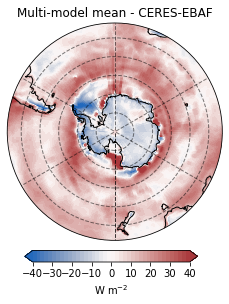

In [15]:
# For PICCAASSO 

fig = plt.figure(figsize=(4,4))

p2,ax = plot_properties([1,1,1],(rsdsCMIP6.sel(Model=likely.values).mean('Model').sel(season='DJF')-obsrsds).rsds,
                     'Multi-model mean - CERES-EBAF',-40,40,
                     cmap=sns.color_palette("vlag", as_cmap=True),supress_alpha='Yes');

cax = plt.axes([0.2, 0.05, 0.6, 0.04])
plt.colorbar(p2,cax=cax,orientation='horizontal',label='W m$^{-2}$');
plt.savefig('/home/563/slf563/code/gadi/jk72/CMIP_eval/CMIP6_model_mean_rsds_bias_likely.pdf',bbox_inches='tight')

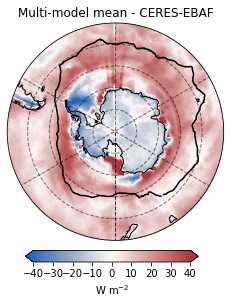

In [16]:
# For Jay  

fig = plt.figure(figsize=(4,4))

p2,ax = plot_properties([1,1,1],(rsdsCMIP6.sel(Model=likely.values).mean('Model').sel(season='DJF')-obsrsds).rsds,
                     'Multi-model mean - CERES-EBAF',-40,40,
                     cmap=sns.color_palette("vlag", as_cmap=True),supress_alpha='Yes',extent='Jay');

ax.plot(pf.lon,pf.lat,transform=ccrs.PlateCarree(),color='black');

cax = plt.axes([0.2, 0.05, 0.6, 0.04])
plt.colorbar(p2,cax=cax,orientation='horizontal',label='W m$^{-2}$');
plt.savefig('/home/563/slf563/code/gadi/jk72/CMIP_eval/CMIP6_model_mean_rsds_bias_likely_for_jay.pdf',bbox_inches='tight')

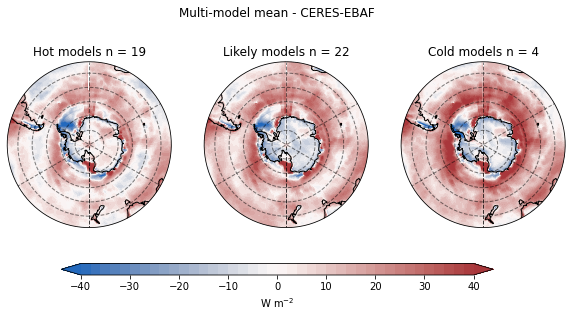

In [17]:
fig = plt.figure(figsize=(10,4))

p2,ax = plot_properties([1,3,1],(rsdsCMIP6.sel(Model=hot.values).mean('Model').sel(season='DJF')-obsrsds).rsds,
                     'Hot models n = {}'.format(np.count_nonzero(hot)),-40,40,
                     cmap=sns.color_palette("vlag", as_cmap=True),supress_alpha='Yes');

p2,ax = plot_properties([1,3,2],(rsdsCMIP6.sel(Model=likely.values).mean('Model').sel(season='DJF')-obsrsds).rsds,
                     'Likely models n = {}'.format(np.count_nonzero(likely)),-40,40,
                     cmap=sns.color_palette("vlag", as_cmap=True),supress_alpha='Yes');

p2,ax = plot_properties([1,3,3],(rsdsCMIP6.sel(Model=cold.values).mean('Model').sel(season='DJF')-obsrsds).rsds,
                     'Cold models n = {}'.format(np.count_nonzero(cold)),-40,40,
                     cmap=sns.color_palette("vlag", as_cmap=True),supress_alpha='Yes');

plt.suptitle('Multi-model mean - CERES-EBAF')

cax = plt.axes([0.2, 0.05, 0.6, 0.04])
plt.colorbar(p2,cax=cax,orientation='horizontal',label='W m$^{-2}$');
plt.savefig('/home/563/slf563/code/gadi/jk72/CMIP_eval/CMIP6_model_mean_rsds_bias_hot_or_not.pdf',bbox_inches='tight')

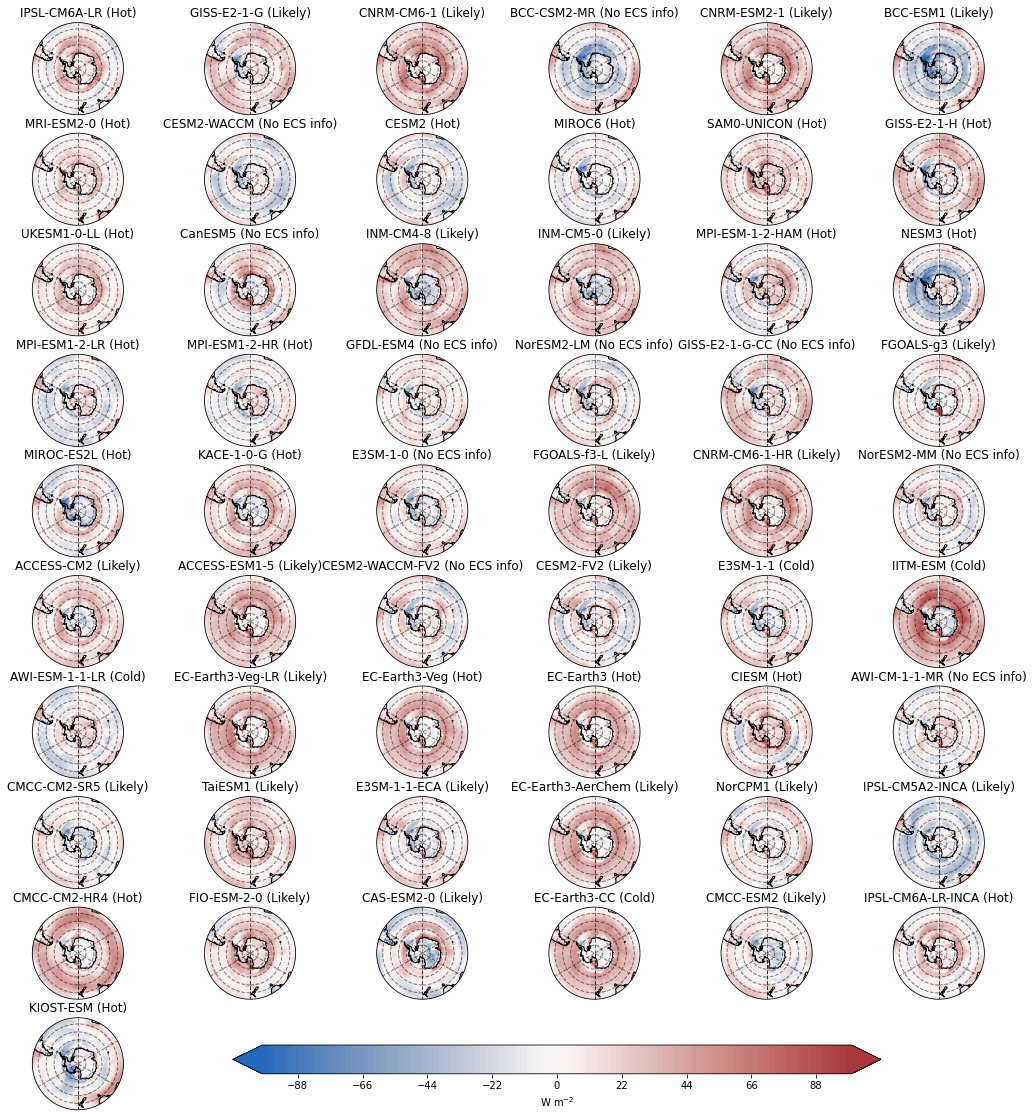

In [18]:
fig = plt.figure(figsize=(18,20))

for i,m in enumerate(rsdsCMIP6.Model.values): 
    p2,ax = plot_properties([10,6,1+i],(rsdsCMIP6.isel(Model=i).sel(season='DJF')-obsrsds).rsds,
                         '{} ({})'.format(m,ECS.Temp.iloc[i]),-100,100,
                         cmap=sns.color_palette("vlag", as_cmap=True),supress_alpha='Yes');
    
cax = plt.axes([0.3, 0.15, 0.5, 0.02])
plt.colorbar(p2,cax=cax,orientation='horizontal',label='W m$^{-2}$');
plt.savefig('/home/563/slf563/code/gadi/jk72/CMIP_eval/CMIP6_individual_models_rsds_bias.pdf')

# Calculate stats 
For Rafel: between 40-70S

In [19]:
data = (rsdsCMIP6.sel(lat=slice(-70,-40)).sel(season='DJF')-obsrsds).rsds
print('Hot models mean rsds bias: ',data.sel(Model=hot.values).mean().values,'W m-2')
print('Likley models mean rsds bias: ',data.sel(Model=likely.values).mean().values,'W m-2')
print('Cold models mean rsds bias: ',data.sel(Model=cold.values).mean().values,'W m-2')

Hot models mean rsds bias:  4.203311 W m-2
Likley models mean rsds bias:  9.796338 W m-2
Cold models mean rsds bias:  15.185572 W m-2
